# Uncovering Income Prediction Logic with RuleFit

#### Trustworthy AI Examples Series

This notebook demonstrates how complex feature interactions can conceal socioeconomic biases in labor-market models. Using the Adults dataset, this example scenario simulates an earnings-prediction pipeline that forecasts whether a person’s income exceeds $50K based on census features. Model explainability is then performed, targeting rule‐based insights by applying the RuleFit algorithm, ultimately surfacing human‐readable rules to audit for fairness and bias.

Policy analysts and civil-rights auditors require not only predictive performance but also the ability to trace how demographic and occupational factors combine to influence income predictions. RuleFit yields both global importance scores and explicit “if-then” rules—making it straightforward to detect and quantify disparities.

Through this scenario, readers will:

1. **Highlight equity concerns**: how hidden logic in income models can perpetuate gender or racial disparities.  
2. **Extract transparent logic**: use RuleFit to learn concise rules and linear terms that explain high-income predictions.  
3. **Perform fairness audits**: evaluate rule support and precision across protected subgroups to identify and mitigate biases.

In [4]:
import sys
from pathlib import Path

PROJECT_ROOT = Path().resolve().parents[1]
sys.path.insert(0, str(PROJECT_ROOT))

## Imports & Utilities

This notebook will use functions from the `preprocessing.py` file located in the `utils` folder. It is recommended to review the file to gain an understanding of the functions being used before continuing. Click [here](../../python/utils/preprocessing.py) to see the file.

### imodels

**imodels** is a library focused on interpretable machine learning, providing implementations of rule-based and tree-based models that are both accurate and understandable. It is used here for:

- `RuleFitClassifier`: builds a sparse linear model using decision rules extracted from tree ensembles.
- `fit`: trains the model by generating rules and selecting a subset that best predicts the target.
- `predict`: applies the learned rules and linear terms to make predictions.
- `get_rules()`: retrieves a list of human-readable rules with associated coefficients and statistics, allowing for easy interpretation of model behavior.

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score, f1_score

from imodels import RuleFitClassifier

import python.utils.preprocessing as pp

## Data Preparation

In order to train a model on the Adult dataset, raw data must be converted into a clean, numeric, and standardized format. After loading the dataset from the CSV file, the first step is to handle any missing values to ensure consistency and avoid errors during model training.

In this case, missing values are imputed using the median of each column, which is a robust strategy that avoids data loss while mitigating the influence of outliers.

To prepare the dataset for modeling, first transform categorical variables using one-hot encoding, excluding the target to preserve its interpretability. Next, apply standardization to the numerical features to ensure they are on a comparable scale, which is crucial for many machine learning algorithms.

The `split_data` splits the data for model training and evaluation.

In [6]:
train_data = pp.load_data(PROJECT_ROOT / 'data/adult_train.csv')
test_data = pp.load_data(PROJECT_ROOT / 'data/adult_test.csv')
df = pd.concat([train_data, test_data], ignore_index=True)
df = pp.handle_missing_values(df, strategy='median')

target_col = 'target'

df_enc = pp.encode_categorical_data(df, method='onehot', exclude_cols=[target_col])
df_scaled = pp.scale_features(df_enc, method='standardize', exclude_cols=[target_col])

X_train, X_test, y_train, y_test = pp.split_data(df_scaled, target_col=target_col, test_size=0.2)

print(f"Training set size: {X_train.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")
print(f"Number of features: {X_test.shape[1] if X_train.shape[1] == X_test.shape[1] else -1}")

Training set size: 28654 samples
Test set size: 7164 samples
Number of features: 126


## RuleFit Model

### Model Training

The `RuleFitClassifier` was trained to predict whether an individual's income exceeds $50K using a combination of linear terms and decision rules. This hybrid approach allows the model to capture both additive effects (e.g., capital gain, hours worked) and complex interactions (e.g., marital status combined with education and occupation).

In [18]:
rf_model = RuleFitClassifier(tree_size=4, sample_fract='default', max_rules=20, memory_par=0.01, random_state=42)
rf_model.fit(X_train.values, y_train.values, feature_names=X_train.columns)

RuleFitClassifier(max_rules=20, random_state=42)

### Model Evaluation

The model summary confirms that predictions are made by summing the coefficients of each rule and linear term. This structure is inherently interpretable, as each component contributes a quantifiable amount to the final prediction.

An accuracy of 84.0% and an F1 score of 0.816 indicate that the model performs well in distinguishing high-income individuals. However, the real strength of RuleFit lies in its ability to explain **why** those predictions are made.

In [19]:
rf_preds = rf_model.predict(X_test.values)

acc = accuracy_score(y_test, rf_preds)
f1 = f1_score(y_test, rf_preds, average='weighted')

print(f"Accuracy: {acc:.3f}")
print(f"F1 Score: {f1:.3f}")

Accuracy: 0.840
F1 Score: 0.816


## Rule Extraction

These rules represent combinations of features that strongly influence the model’s prediction of high income. Each rule includes its support, coefficient, and importance score.

The extracted rules reveal how the model combines multiple features to form decision logic. For example:

**Rule 1:**
`capital_gain <= 0.79783 and capital_loss <= 5.26175 and marital_status_Married-civ-spouse <= 0.5`
- This rule has the highest coefficient (6.56) and applies to over 52% of the population. It suggests that individuals who are not married and have low capital gains/losses are strongly associated with lower income predictions.

**Rule 2:**
`capital_gain <= 0.53434 and capital_loss <= 4.2403 and education_Prof-school <= 0.5 and education_num_14 <= 0.5 and marital_status_Married-civ-spouse > 0.5`
- This rule applies to married individuals with moderate education and low capital gains/losses, and it also contributes significantly to the prediction.

**Rule 5:**
`capital_gain <= 0.79783 and education_Masters <= 0.5 and marital_status_Married-civ-spouse <= 0.5`
- This rule highlights how the absence of a master’s degree, combined with being unmarried and having low capital gains, is associated with lower income.

Overall, these rules clearly proves themselves to not only be predictive, but reflective of social circumstance. They reflect how certain societal structures, like marital status, education, and capital access, interact in ways that may reinforce existing socioeconomic disparities.

In [ ]:
rules_list = []
for r in rf_model.rules_:
    agg_vals = list(map(float, r.agg_dict.values())) if r.agg_dict else []
    coef = sum(agg_vals) if agg_vals else 0

    rules_list.append({
        'rule': r.rule,
        'support': r.support,
        'coef': coef
    })

rules_df = pd.DataFrame(rules_list)
rules_df = rules_df[rules_df['coef'] != 0]

rules_df['abs_coef'] = rules_df['coef'].abs()
rules_df = rules_df.sort_values(by='abs_coef', ascending=False)

print("Top 10 Rules by aggregated coefficient magnitude:")
print(rules_df.head(10))

Top 10 Rules by aggregated coefficient magnitude:
                                                                                                                                                                                   rule  \
3                                                                                      capital_gain <= 0.79783 and capital_loss <= 5.26175 and marital_status_Married-civ-spouse <= 0.5   
10                          capital_gain <= 0.53434 and capital_loss <= 4.2403 and education_Prof-school <= 0.5 and education_num_14 <= 0.5 and marital_status_Married-civ-spouse > 0.5   
4                                                                capital_gain <= 0.53434 and capital_loss <= 4.28847 and hours_per_week <= 0.33018 and occupation_Prof-specialty <= 0.5   
2                                                                                                               age <= -0.66792 and capital_gain <= 0.41837 and capital_loss <= 4.42928   
0   age > -0.59

## Global Feature Importance

This plot highlights the most influential rule-based features, showing which combinations of attributes drive income predictions. It shows that:

- Capital gain appears in nearly every top rule, underscoring its strong association with high income.
- Marital status is a recurring factor, often interacting with education and occupation.
- Education level and occupation type also play key roles, particularly in rules that suppress high-income predictions.

<Figure size 1000x600 with 0 Axes>

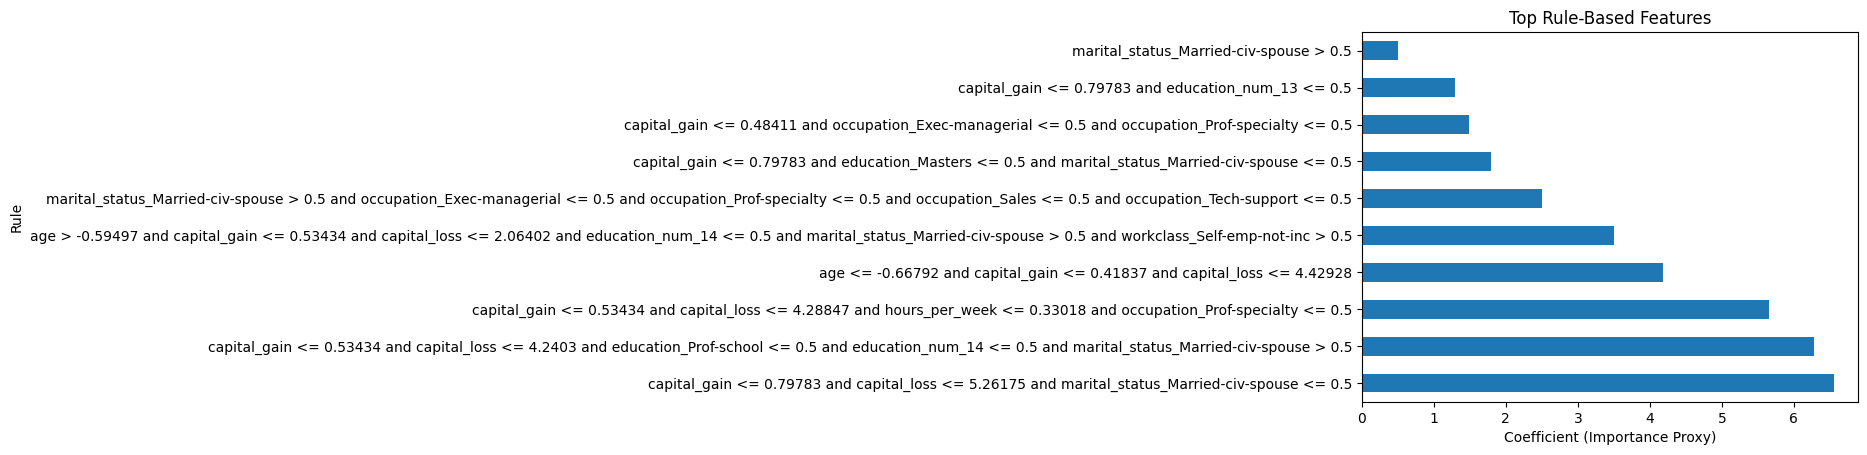

In [31]:
plt.figure(figsize=(10, 6))
rules_df.head(10).plot.barh(x='rule', y='coef', legend=False)
plt.title("Top Rule-Based Features")
plt.xlabel("Coefficient (Importance Proxy)")
plt.ylabel("Rule")
plt.show()

## Fairness Audit

To assess fairness, the support and precision of top rules can be compared across protected groups (e.g., gender, race). This analysis helps identify whether certain rules disproportionately apply to specific subgroups, which may signal bias. Several of the top rules disproportionately affect individuals based on marital status, education, and occupation. For example, rules that penalize those who are not married or lack advanced degrees may inadvertently reflect or reinforce systemic inequalities.

To assess fairness, the top rule was evaluated for its support rate among males, which came out to 47%. This means that nearly half of the male individuals in the test set satisfy the conditions of this rule. Given that the rule contributes negatively to income prediction, this could indicate that a substantial portion of male individuals are being classified as low-income due to this combination of features.

In [37]:
def add_backticks_to_columns(rule_str, columns):
    columns_sorted = sorted(columns, key=len, reverse=True)

    for col in columns_sorted:
        if col in rule_str and f"`{col}`" not in rule_str:
            rule_str = rule_str.replace(col, f"`{col}`")
    return rule_str


In [ ]:
top_rule = rules_df.iloc[0]['rule']

fixed_rule = add_backticks_to_columns(top_rule, X_test.columns)
rule_mask = X_test.query(fixed_rule).index

protected_attr = 'sex_Male'
support_rate = X_test.loc[rule_mask, protected_attr].mean()
print(f"Support for top rule among males: {support_rate:.2f}")

Support for top rule among males: 0.47


## Takeaway

This notebook explored how interpretable machine learning can be used to uncover the logic behind income prediction models.

By applying the RuleFit algorithm, the pipeline revealed how combinations of demographic, occupational, and financial features influence whether an individual is predicted to earn more than $50K annually.

The RuleFit model achieved strong predictive performance (accuracy: 84.0%, F1 score: 0.816), but more importantly, it surfaced a set of transparent, rule-based explanations. A fairness audit of the top rule revealed that it applied to 47% of male individuals, suggesting that even rules with high predictive value can disproportionately affect certain groups. This displays the importance of evaluating a model's distributional impact across protected attributes like gender. By making model logic visible and testable, practitioners can move beyond accuracy alone and toward models that are both trustworthy and socially responsible.